In [106]:
import pprint
from datetime import date
import json
from intervalsicu import Intervals
import pandas as pd
import requests
from requests.auth import HTTPBasicAuth
from datetime import datetime, timedelta
import csv
from fitparse import FitFile
import os
import matplotlib.pyplot as plt

In [107]:


def plot_outdoor_ride(df, save_path = None):

    fig, ax1 = plt.subplots(figsize=(12, 10))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    ax1.plot(df.index, df['heart_rate'], color='brown', label='HR')
    ax2.plot(df.index, df['enhanced_altitude'], color='pink', label='Altitude')
    ax3.plot(df.index, df['enhanced_speed'], color='green', label='speed')

    ax1.set_ylabel('HR(bpm)')
    ax1.grid()

    ax2.set_ylabel('Altitude(m)')
    ax2.grid()
    ax3.set_ylabel('Speed(m/s)')
    ax3.grid()
    # ax3.legend()

    # combine the legends into one
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

    # plt.grid()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show() 


def plot_indoor_ride(df, save_path = None):

    fig, ax1 = plt.subplots(figsize=(12, 10))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    ax1.plot(df.index, df['power'], color='red', label='Power')
    ax2.plot(df.index, df['cadence'], color='blue', label='Cadence')
    ax3.plot(df.index, df['enhanced_speed'], color='green', label='Speed')

    ax1.set_ylabel('Power(W)')
    ax1.grid()

    ax2.set_ylabel('Cadence(rpm)')
    ax2.grid()
    ax3.set_ylabel('Speed(m/s)')
    ax3.grid()
    # ax3.legend()

    # combine the legends into one
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

    # plt.grid()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()  



In [108]:
env_file = "/hdd/side_projects/imu_project/env.json"
with open(env_file, 'r') as f:
    env_data = json.load(f)
    
headers = {
    "Authorization": f"Bearer {env_data['intervals_icu']['api_key']}"
}

athlete_id = env_data["intervals_icu"]["athlete_id"]
api_key = env_data["intervals_icu"]["api_key"]

# Base URL for the Intervals.icu API
base_url = "https://intervals.icu/api/v1"

# Function to get all events for the athlete
def get_all_activities():
    events_url = f"{base_url}/athlete/{athlete_id}/events.csv"
    response = requests.get(events_url, auth=HTTPBasicAuth('API_KEY', api_key))
    response.raise_for_status()  # Raise an error for bad status codes
    return response

def get_recent_activities(days=30):
    """
    Fetches activities from the current day up to 'days' days prior.

    Parameters:
    - days (int): Number of days to look back from today. Default is 30.

    Returns:
    - list: A list of activity dictionaries within the specified date range.
    """
    # Calculate date range
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=days)

    # Format dates in ISO 8601 format (YYYY-MM-DD)
    start_date_str = start_date.isoformat()
    end_date_str = end_date.isoformat()

    # Construct the API endpoint with query parameters
    activities_url = f"{base_url}/athlete/{athlete_id}/activities?oldest={start_date_str}&newest={end_date_str}"

    try:
        # Make the GET request to fetch activities
        response = requests.get(activities_url, auth=HTTPBasicAuth('API_KEY', api_key))
        response.raise_for_status()  # Raise an error for bad status codes
        activities = response.json()
        return activities
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching activities: {e}")
        return []

def download_fit_file(activity_id, save_path):
    """
    Downloads the FIT file for a given activity ID from Intervals.icu and saves it to the specified location.

    Parameters:
    - activity_id (str): The ID of the activity whose FIT file is to be downloaded.
    - save_path (str): The file path where the FIT file will be saved.
    - api_key (str): Your Intervals.icu API key.

    Returns:
    - None
    """
    # Construct the URL for the FIT file download
    fit_file_url = f"https://intervals.icu/api/v1/activity/{activity_id}/fit-file"

    try:
        # Make the GET request to download the FIT file
        response = requests.get(fit_file_url, auth=HTTPBasicAuth('API_KEY', api_key))
        response.raise_for_status()  # Raise an error for bad status codes

        # Save the FIT file to the specified location
        with open(save_path, 'wb') as fit_file:
            fit_file.write(response.content)
        print(f"FIT file successfully downloaded and saved to {save_path}")

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while downloading the FIT file: {e}")

records_to_store = ['enhanced_speed', 'enhanced_altitude', 'cadence', 'power',
                    'heart_rate', 'timestamp', 'position_lat', 'position_long']

def fit_to_csv(fit_file_path, csv_file_path):
    """
    Converts a FIT file to a CSV file.

    Parameters:
    - fit_file_path: str, path to the input FIT file.
    - csv_file_path: str, path to the output CSV file.
    """
    # Load the FIT file
    fitfile = FitFile(fit_file_path)

    # Open the CSV file for writing
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        # Initialize a flag to write headers only once
        headers_written = False

        # Iterate over all messages of type 'record'
        for record in fitfile.get_messages('record'):
            record_data = {}

            # Extract data from each record
            for data in record:
                if data.name in records_to_store:
                    # print (data.name, data.value)
                    record_data[data.name] = data.value

            # Write the header row if not already written
            if not headers_written:
                headers = record_data.keys()
                csv_writer.writerow(headers)
                headers_written = True

            # Write the data row
            csv_writer.writerow(record_data.values())

    print(f"Conversion complete. CSV file saved as '{csv_file_path}'.")


# events = get_all_activities()

In [109]:
data_folder = "/hdd/side_projects/imu_project/data/garmin_data"
os.makedirs(data_folder, exist_ok=True)

acts = get_recent_activities(days=30)

bike_event_ids = []
indoor_bike_even_ids = []

for act in acts:
    if "ride" in act['type'].lower():
        bike_event_ids.append(act['id'])

for idx, act in enumerate(acts):
    if "ride" in act['type'].lower():
        event_id = act['id']
        timestamp = act['start_date_local']
        type = act['type']
        # convert the timestamp to YYYYMMDDHHMM
        timestamp = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S')
        timestamp = timestamp.strftime('%Y_%m_%d_%H%M')
        file_name = f"{data_folder}/{type}_{timestamp}_{event_id}.fit"
        
        if not os.path.exists(file_name):
            download_fit_file(event_id, file_name)
            fit_to_csv(file_name, file_name.replace(".fit", ".csv") )
    
    
    # elif "virtualride" in act['type'].lower():
    #     indoor_bike_even_ids.append(act['id'])


In [110]:
df = pd.read_csv("/hdd/side_projects/imu_project/data/garmin_data/VirtualRide_2025_03_19_1624_i70136187.csv")
df.head()   
df1 = pd.read_csv("/hdd/side_projects/imu_project/data/garmin_data/Ride_2025_04_02_1707_i72273748.csv")
print (df1.head())

   enhanced_altitude  enhanced_speed  heart_rate  position_lat  position_long  \
0               17.0           3.835          99     607117676       56147114   
1               17.2           3.919         101     607117767       56147052   
2               17.2           4.264         102     607118267       56147211   
3               17.2           4.889         104     607118904       56147302   
4               17.2           5.085         107     607119405       56147279   

             timestamp  
0  2025-04-02 15:07:00  
1  2025-04-02 15:07:01  
2  2025-04-02 15:07:02  
3  2025-04-02 15:07:03  
4  2025-04-02 15:07:04  


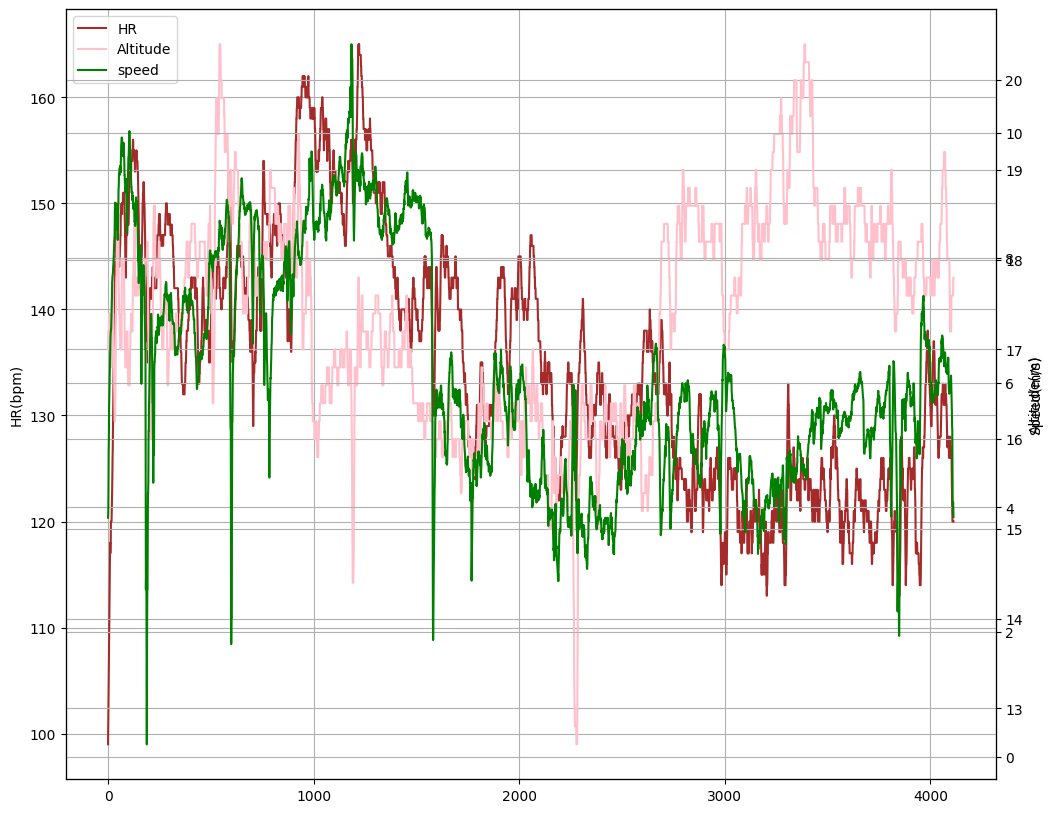

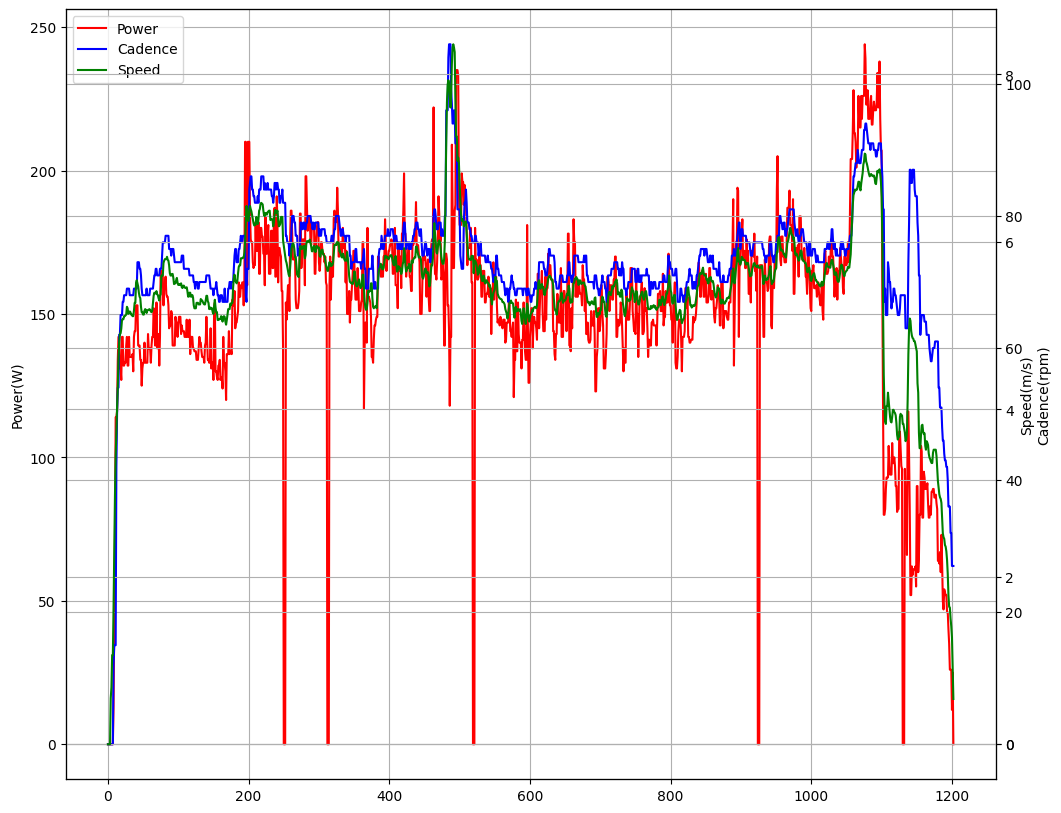

In [111]:
plot_outdoor_ride(df1)
plot_indoor_ride(df)